# Zigosity
Can we build a classifier that can tell from ASV/taxonomic assignment whether the 2 samples are monozygotic, dizygotic or not related?

In [73]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import qiime2 as q2
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

data_dir = 'data' #data from polybox (ASV, taxonomy analysis)
or_dir = '../data'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

In [2]:
! wget -nv -O $data_dir/PJNB_dada2_table-filtered.qza 'https://polybox.ethz.ch/index.php/s/q2dsg2JxeJz3hko/download'

2022-11-20 16:06:55 URL:https://polybox.ethz.ch/index.php/s/q2dsg2JxeJz3hko/download [1818719/1818719] -> "data/PJNB_dada2_table-filtered.qza" [1]


In [74]:
table_ASV = q2.Artifact.load(f'{data_dir}/PJNB_dada2_table-filtered.qza').view(pd.DataFrame)

In [75]:
metadata = pd.read_csv(or_dir + '/metadata.tsv', sep = '\t', index_col = 'id')
table_ASV_metadata = pd.merge(table_ASV, metadata, left_index=True, right_index=True)
ASVs_cols = table_ASV_metadata.columns[0:-25]
print(table_ASV_metadata.columns[-25:])
print(table_ASV_metadata.head())

Index(['Library Layout', 'Instrument', 'collection_date', 'geo_location_name',
       'geo_latitude', 'geo_longitude', 'host_id', 'age_days', 'weight_kg',
       'length_cm', 'WAZ', 'HAZ', 'WHZ', 'BMI', 'birth_weight_g',
       'birth_length_cm', 'sex', 'delivery_mode', 'zygosity', 'race',
       'ethnicity', 'delivery_preterm', 'diet_milk', 'diet_weaning',
       'age_months'],
      dtype='object')
            d7ccfef4d1779d9899c71c078d577f53  \
ERR1309715                               0.0   
ERR1309716                               0.0   
ERR1309717                               0.0   
ERR1309718                               0.0   
ERR1309719                               0.0   

            09e9b81594db403cebe45252798e9f1a  \
ERR1309715                               0.0   
ERR1309716                               0.0   
ERR1309717                               0.0   
ERR1309718                               0.0   
ERR1309719                               0.0   

            a25546

Monozygotic    870
Dizygotic      755
Unknown         44
Name: zygosity, dtype: int64
['Dizygotic' 'Monozygotic' 'Unknown']
            d7ccfef4d1779d9899c71c078d577f53  \
ERR1309715                         -0.105613   
ERR1309716                         -0.105613   
ERR1309717                         -0.105613   
ERR1309718                         -0.105613   
ERR1309719                         -0.105613   

            09e9b81594db403cebe45252798e9f1a  \
ERR1309715                         -0.024815   
ERR1309716                         -0.024815   
ERR1309717                         -0.024815   
ERR1309718                         -0.024815   
ERR1309719                         -0.024815   

            a25546433b23185d30d42c6f17919bf5  \
ERR1309715                         -0.124725   
ERR1309716                         -0.124725   
ERR1309717                         -0.124725   
ERR1309718                         -0.124725   
ERR1309719                         -0.124725   

         

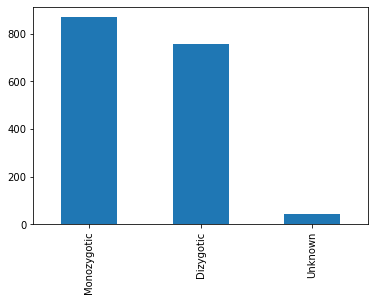

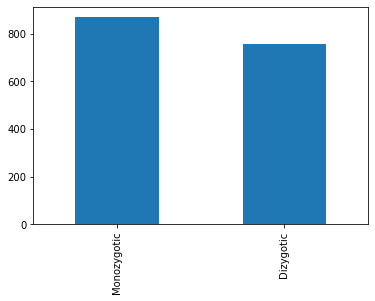

In [76]:
table_ASV_metadata['zygosity'].value_counts().plot(kind='bar')
print(table_ASV_metadata['zygosity'].value_counts())
print(table_ASV_metadata['zygosity'].unique())

# drop unknown zigosity columns
table_ASV_metadata = table_ASV_metadata.loc[table_ASV_metadata['zygosity'] != 'Unknown', ]
plt.figure()
table_ASV_metadata['zygosity'].value_counts().plot(kind='bar')

# normalize the ASV data per column
inter = pd.DataFrame(StandardScaler().fit_transform(table_ASV_metadata[ASVs_cols]))
inter.columns = ASVs_cols
inter.set_index(table_ASV_metadata[ASVs_cols].index, inplace = True)
table_ASV_metadata[ASVs_cols] = inter
print(table_ASV_metadata.head())

# To do 
1. Data loader: want for training: 600 mono, 600 di and 600 unrelated samples. Save the id's of other samples for validation
2. 

## Load data

In [77]:
hosts_ids = table_ASV_metadata['host_id'].astype(int).unique()

Create table with id's of same point twins and their class so can use this as input to the trainer

In [78]:
### Dataframe that tells you the index of the first baby, the second baby and their label
# match for age
non_related = [random.choice(hosts_ids) for _ in range(600)]
baby_id1 = list()
baby_id2 = list(); zygosity_ = list()
for host in hosts_ids:
#for host in [10, 12]:
    # get the dataframe for each baby
    first = table_ASV_metadata.loc[table_ASV_metadata['host_id'] == host+0.1,].sort_values(by = 'age_days', ascending = True)
    second = table_ASV_metadata.loc[table_ASV_metadata['host_id'] == host+0.2,] .sort_values(by = 'age_days', ascending = True)
    # get the zygosity
    zig = first['zygosity']
    # match by age as well as possible
    ages_1 = first['age_days']
    ages_2 = first['age_days']
    
    # check if any twins were not measures at same timepoint
    if len(ages_1) == len(ages_2):
        if list(ages_1) != list(ages_2):
            print(host, 'have different sample times')
    else:
        print(host, ' have different number of samples')
    
    baby_id1.extend(list(first.index))
    baby_id2.extend(list(first.index))
    zygosity_.extend(list(zig))

Babies = pd.DataFrame(baby_id1, columns = ['Baby1'])
Babies['Baby2'] = baby_id2
Babies['Zygosity'] = zygosity_
# convert categorical string variables to integers 
# Creating a instance of label Encoder.
le = LabelEncoder()
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(Babies['Zygosity']) # Dizygotic: 0, monozygotic: 1
Babies['Zygosity'] = label

In [79]:
print(Babies.head())
print(len(ASVs_cols))
print(le)
#print(zygosity_)

        Baby1       Baby2  Zygosity
0  ERR1310569  ERR1310569         0
1  ERR1310570  ERR1310570         0
2  ERR1310571  ERR1310571         0
3  ERR1309880  ERR1309880         0
4  ERR1309881  ERR1309881         0
5072
LabelEncoder()


In [119]:
class Doublet_baby(Dataset):
    """2 babies: they are either related: monozygotic or dyzygotic or they are unrelated.
        get the ASVs of these babies, normalize
    """

    def __init__(self, doubls, feats):
        """
        Args:
            doubls = dataframe: columns: Baby1, Baby2, zigosity
            feats = ASV feature table, rows are samples index by ID, columns ASVs and metadata
        """
        self.doublets = doubls
        self.features = feats

    def __len__(self):
        return len(self.doublets)

    def __getitem__(self, idx):

        indices = self.doublets.loc[idx, ] #paths
        feat1 = self.features.loc[indices['Baby1'], ASVs_cols]
        feat2 = self.features.loc[indices['Baby2'], ASVs_cols]
        feat1 = torch.from_numpy(np.array(feat1, np.float32))
        feat2 = torch.from_numpy(np.array(feat2, np.float32))
        label = torch.from_numpy(np.array(indices['Zygosity']))
        
        return feat1, feat2, label #ADD LABELSSS


In [120]:
Babies

,Baby1,Baby2,Zygosity
0,ERR1310569,ERR1310569,0
1,ERR1310570,ERR1310570,0
2,ERR1310571,ERR1310571,0
3,ERR1309880,ERR1309880,0
4,ERR1309881,ERR1309881,0
...,...,...,...
803,ERR1314887,ERR1314887,1
804,ERR1314752,ERR1314752,1
805,ERR1314457,ERR1314457,1
806,ERR1314836,ERR1314836,1


In [133]:
# split train and test dataset 80% 20%
train_part = Babies.sample(frac = 0.8, axis = 'index', random_state = 42) #, ignore_index = True) not in pandas version of jupyterlab :()
all_ind = Babies.index
tr_index = train_part.index
test_part = Babies.loc[list(set(all_ind)-set(tr_index)), :]
train_part = train_part.reset_index()
test_part = test_part.reset_index()
print(test_part)
train_set = Doublet_baby(train_part, table_ASV_metadata)
test_set = Doublet_baby(test_part, table_ASV_metadata)

     index       Baby1       Baby2  Zygosity
0        1  ERR1310570  ERR1310570         0
1        4  ERR1309881  ERR1309881         0
2      520  ERR1315021  ERR1315021         0
3      524  ERR1314715  ERR1314715         0
4       13  ERR1309716  ERR1309716         0
..     ...         ...         ...       ...
157    498  ERR1313918  ERR1313918         1
158    502  ERR1315655  ERR1315655         0
159    504  ERR1313907  ERR1313907         0
160    508  ERR1313696  ERR1313696         0
161    510  ERR1315615  ERR1315615         0

[162 rows x 4 columns]


In [134]:
# Loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #takes dataset and loads it and splits --> batches of certain size
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

## Neural network


In [96]:
num_feat = len(ASVs_cols)
#def predicting(data, MODEL)

In [139]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.part = nn.Sequential(
          nn.Linear(num_feat, 500),
          nn.ReLU(inplace = True),
          nn.BatchNorm1d(500),
          nn.Dropout(p=0.5),
          nn.Linear(500, 50),
          nn.ReLU(inplace = True),
          nn.BatchNorm1d(50),
          nn.Dropout(p=0.5),
          nn.Linear(50, 50) # feature vector is created 
        )
        self.compare = nn.Sequential(
          nn.Conv2d(2, 18, kernel_size = 2, stride = 1, padding = 1),
          nn.Flatten(),
          nn.Linear(10, 2) #2 classes: monozygotic or dyzygotic #WHATS THE SIZE?????
        )
    def forward(self, x1, x2):
        x1 = self.part(x1)
        x2 = self.part(x2)
        y = self.compare(torch.cat((x1, x2), dim=2)) #HOW TO CONCAT THIS --> 2 row matrix of encondings.
        return y

In [98]:
def evaluate(data, MODEL):
    MODEL.eval()
    correct = 0
    for i, data in enumerate(data, 0):
        input1, input2, labels = data
        __, predict = torch.max( MODEL(input1, input2), 1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()
    print(f'Accuracy of the network on the {len(testdata)} test data: {100 * correct // total} %')

In [99]:
net = Network()

In [100]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = net.parameters(), lr=1e-3)

In [140]:
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        print(i)
        input1, input2, labels = data
        # set optimizer to zero grad to remove previous epoch gradients
        optimizer.zero_grad()
        net.train()
        # forward propagation
        outputs = net(input1, input2)
        loss = criterion(outputs, labels)
        # backward propagation
        loss.backward()
        # optimize
        optimizer.step()
        running_loss += loss.item()
        # display statistics
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.5f}')
    evaluate(test_loader, net)

0


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not tuple

In [141]:
outputs

(tensor([[ 0.7496, -1.4059],
         [ 0.1989,  0.6306],
         [ 0.0230, -0.1334],
         [-0.2751,  0.8323],
         [ 1.1012, -1.0874],
         [-0.4003, -0.1794],
         [ 0.7513, -0.6187],
         [-0.6639, -0.3383],
         [ 0.6930,  0.2636],
         [ 0.9813,  0.0290],
         [-1.9610,  0.5959],
         [-0.6315, -0.8935],
         [ 0.1617,  0.9481],
         [ 0.0179,  0.3680],
         [-0.1511,  1.0573],
         [ 0.2860,  0.1807],
         [-1.0074,  0.8606],
         [ 0.0448, -0.2837],
         [ 0.8527, -0.0879],
         [-1.5555, -0.7072],
         [-0.7678,  1.1842],
         [ 1.5203, -0.9333],
         [-0.9352,  2.4218],
         [ 0.1822,  0.0996],
         [-0.4307,  0.8662],
         [ 0.3974,  1.8528],
         [ 1.8582, -0.1867],
         [ 0.3098, -0.5531],
         [-0.1508, -1.6902],
         [-1.4600,  0.1678],
         [-0.1490, -0.1504],
         [-0.6878, -0.2577]], grad_fn=<AddmmBackward0>),
 tensor([[-0.4970,  0.6955],
         [ 1.11